# Create Context

In [1]:
import os

In [ ]:
from dotenv import load_dotenv

load_dotenv()

In [2]:
from llama_index.core import Settings
from llama_index.llms.openai import OpenAI

# changing the global default
Settings.llm = OpenAI(model="o4-mini")

In [3]:
from IPython.display import Markdown, display

In [4]:
from llama_index.core import SummaryIndex
from llama_index.readers.web import SimpleWebPageReader
from IPython.display import Markdown, display
import os

In [5]:
# Crawl domain with deeper crawling following subpages
from llama_index.readers.web import SpiderWebReader

spider_reader = SpiderWebReader(
    api_key="sk-9bfd2108-e0e7-42f6-a49f-a1d13b9f0e73",
    mode="crawl",
    # params={} # Optional parameters see more on https://spider.cloud/docs/api
)

In [6]:
#documents = spider_reader.load_data(url="https://microservices.io/patterns/index.html")

In [7]:
#print(documents[0])

In [6]:
from llama_index.core import Document
from llama_index.embeddings.openai import OpenAIEmbedding
from llama_index.core.node_parser import SentenceSplitter
from llama_index.core.extractors import TitleExtractor
from llama_index.core.ingestion import IngestionPipeline, IngestionCache
from llama_index.vector_stores.qdrant import QdrantVectorStore
# Create your index
from llama_index.core import VectorStoreIndex
import qdrant_client

In [7]:
lock_file = os.path.join("/Users/marcocalamo/home/archi", ".lock")
if os.path.exists(lock_file):
     os.remove(lock_file)

os.makedirs("/Users/marcocalamo/home/archi", exist_ok=True)

In [8]:
client = qdrant_client.AsyncQdrantClient(path="/Users/marcocalamo/home/archi")
vector_store = QdrantVectorStore(aclient=client, collection_name="micro", use_async=True)

In [9]:
index_sito = VectorStoreIndex.from_vector_store(vector_store)

# Pipelining

In [12]:
#pipeline = IngestionPipeline(
#    transformations=[
#        SentenceSplitter(chunk_size=1824, chunk_overlap=0),
#        #TitleExtractor(),
#        OpenAIEmbedding(),
#    ],
#    vector_store=vector_store,
#)

# Ingest directly into a vector db
#pipeline.run(documents=documents)

In [13]:
#index_sito = VectorStoreIndex.from_vector_store(vector_store)

# RAG (OLD)

In [14]:
#retriever = index.as_retriever()
#nodes = retriever.retrieve("MicroArchitecture patterns")

In [15]:
#from llama_index.core.postprocessor import SimilarityPostprocessor

In [16]:
# filter nodes below 0.75 similarity score
#processor = SimilarityPostprocessor(similarity_cutoff=0.75)
#filtered_nodes = processor.postprocess_nodes(nodes)

In [17]:
#resp = OpenAI().complete("Tell me about all microarchitecture patterns you know ")
#print(resp)

In [18]:
from llama_index.core.data_structs import Node
from llama_index.core.response_synthesizers import ResponseMode
from llama_index.core import get_response_synthesizer

response_synthesizer = get_response_synthesizer(
    response_mode=ResponseMode.COMPACT
)

#response = response_synthesizer.synthesize(
#    "Tell me about all microarchitecture patterns you know", nodes=nodes
#)

In [19]:
#display(Markdown(f"{response.response}"))

# Workflow

In [10]:
from llama_index.core.workflow import Event
from llama_index.core.schema import NodeWithScore
from typing import Any

class RetrieverEvent(Event):
    """Result of running retrieval"""

    nodes: list[NodeWithScore]


class CreateCitationsEvent(Event):
    """Add citations to the nodes."""

    nodes: list[NodeWithScore]


class MicroservicesExtractedEvent(Event):
    """Get list of microservices from specs and user stroies"""

    microservices_list: list[str]


class ContextRetrievedEvent(Event):
    """Get ready to generate final output with context and ms. list"""

    context: Any

In [11]:
from llama_index.core.prompts import PromptTemplate

CITATION_QA_TEMPLATE = PromptTemplate(
    "Please provide an answer based solely on the provided sources. "
    "When referencing information from a source, "
    "cite the appropriate User Story(ies) using their corresponding numbers. "
    "Every answer should include at least one source citation. "
    "Only cite a source when you are explicitly referencing it. "
    "If none of the sources are helpful, you should indicate that. "
    "For example:\n"
    "User Story 1:\n"
    "The sky is red in the evening and blue in the morning.\n"
    "User Story 2:\n"
    "Water is wet when the sky is red.\n"
    "Query: When is water wet?\n"
    "Answer: Water will be wet when the sky is red [2], "
    "which occurs in the evening [1].\n"
    "Now it's your turn. Below are several numbered sources of information:"
    "\n------\n"
    "{context_str}"
    "\n------\n"
    "Query: {query_str}\n"
    "Answer: "
)

CITATION_REFINE_TEMPLATE = PromptTemplate(
    "Please provide an answer based solely on the provided sources. "
    "When referencing information from a source, "
    "cite the appropriate source(s) using their corresponding numbers. "
    "Every answer should include at least one source citation. "
    "Only cite a source when you are explicitly referencing it. "
    "If none of the sources are helpful, you should indicate that. "
    "For example:\n"
    "User Story 1:\n"
    "The sky is red in the evening and blue in the morning.\n"
    "User Story 2:\n"
    "Water is wet when the sky is red.\n"
    "Query: When is water wet?\n"
    "Answer: Water will be wet when the sky is red [2], "
    "which occurs in the evening [1].\n"
    "Now it's your turn. "
    "We have provided an existing answer: {existing_answer}"
    "Below are several numbered sources of information. "
    "Use them to refine the existing answer. "
    "If the provided sources are not helpful, you will repeat the existing answer."
    "\nBegin refining!"
    "\n------\n"
    "{context_msg}"
    "\n------\n"
    "Query: {query_str}\n"
    "Answer: "
)



DEFAULT_CITATION_CHUNK_SIZE = 512
DEFAULT_CITATION_CHUNK_OVERLAP = 20

In [12]:
EXTRACT_MICROSERVICES_TEXT = """
You will be ask to extract a list of microservices from specifications and user stories.
Report the list in a format like this:

['Microservice1',  'Mircoservice2', ...]

The context is:

Specifications:
--------------------
{{specs}}
--------------------

User Stories:
--------------------
{{user_stories}}
--------------------

The microservice list is:
"""

In [13]:
FIND_CONTEXT_TEXT= """
What are the best microservices patters to use for for this microservices list {{microservices_list}} given this user stories: {{user_stories}} and descriptions:{{specs}}?
"""

In [186]:
USE_CONTEXT_TEXT = """
Given a microservice list, text specifications and user stories of a software,
use context to find the best implementation pattern for each microservice.
Include an explaination on what source made you make a certain choice.
Add also what endpoints are implemented if needed for each microservice, with a corresponding description of inputs and outputs.
Add for every micorservice what user stories it implements, indicating it with their corresponding number, and only the number. All user stories must be implemented.
Find also which microservices require a dataset and provide a brief description of it by saying what user stories influenced your choices.
Output data in a json format like this:

{
    microservices: [
        { 
            name: "name1",
            endpoints: [],
            user_stories: ["story1"]
        }, 
        {
            name: "name2",
            endpoints: [
                { 
                    name: "/login",
                    description: "takes user email and password as inputs and outputs the login result"
                }, 
                {
                    name:"/register"
                    description: "takes user email and password as inputs and outputs the registration result"
                }
            ]
            user_stories: ["story2", "story3"]
        } 
    ],
    patterns: [
            {
                group_name : "meaningful name",
                implementation_pattern: "saga",
                involved_microservices: ["name1", "name2"],
                explaination: "xyz"
                
            },
            {
                group_name : "meaningful name",
                implementation_pattern: "api gateway",
                involved_microservices: ["name3"],
                explaination: "vwq"
            }
    ],
    datasets: [
            {
                dataset_name: "meaningful name",
                associtated_microservice: "name3",
                description: "desc"
            },
    ]

}



The context is:

Retrieved Context
--------------------
{{context}}
--------------------

Microservice List
--------------------
{{microservice_list}}
--------------------

Specifications:
--------------------
{{specs}}
--------------------

User Stories:
--------------------
{{user_stories}}
--------------------

The output json is:
"""

In [187]:
NETWORKX_PROMPT = """
Given as an input a json file describing a microservice architecture and its pattern like this:
{
    microservices: [
        { 
            name: "name1",
            endpoints: [],
            user_stories: [1]
        }, 
        {
            name: "name2",
            endpoints: [
                { 
                    name: "/login",
                    description: "takes user email and password as inputs and outputs the login result"
                }, 
                {
                    name:"/register"
                    description: "takes user email and password as inputs and outputs the registration result"
                }
            ]
            user_stories: [2, 3]
        } 
    ],
    patterns: [
            {
                group_name : "meaningful name",
                implementation_pattern: "saga",
                involved_microservices: ["name1", "name2"],
                explaination: "xyz"
                
            },
            {
                group_name : "meaningful name",
                implementation_pattern: "api gateway",
                involved_microservices: ["name3"],
                explaination: "vwq"
            }
    ],
    datasets: [
            {
                dataset_name: "meaningful name",
                associtated_microservice: "name3",
                description: "desc"
            },
    ]

}

Extract a graph in the format of a dictionary of lists adjacency, with microservices that communicate for each other using info in patterns.
For example:

{ microservice1: [microservice2, microservice3],}

The input json is:
--------------------
{{input_json}}
--------------------

Use microservices names to compose the list. Include all microservices in the json. Answer with the adjacency list and nothing else.
The adjacency list is:
"""

In [26]:
from llama_index.core.prompts import RichPromptTemplate
import json
import ast

In [27]:
from llama_index.core import SimpleDirectoryReader, VectorStoreIndex
from llama_index.core.workflow import (
    Context,
    Workflow,
    StartEvent,
    StopEvent,
    step,
)

from llama_index.llms.openai import OpenAI
from llama_index.embeddings.openai import OpenAIEmbedding

from llama_index.core.schema import (
    MetadataMode,
    NodeWithScore,
    TextNode,
)

from llama_index.core.response_synthesizers import (
    ResponseMode,
    get_response_synthesizer,
)

from typing import Union, List
from llama_index.core.node_parser import SentenceSplitter
from llama_index.core.retrievers import QueryFusionRetriever


class CitationQueryEngineWorkflow(Workflow):
    @step
    async def retrieve(
        self, ctx: Context, ev: StartEvent
    ) -> Union[RetrieverEvent, None]:
        "Entry point for RAG, triggered by a StartEvent with `query`."

        
        query = ev.get("query")
        if not query:
            return None

        #print(f"Query the database with: {query}")

        # store the query in the global context
        await ctx.set("query", query)

        if ev.retriever is None:
            print("Retriever is empty, load some documents before querying!")
            return None

        
        #retriever = index
        nodes = ev.retriever.retrieve(query)
        print(f"Retrieved {len(nodes)} nodes.")
        return RetrieverEvent(nodes=nodes)

    @step
    async def create_citation_nodes(
        self, ev: RetrieverEvent
    ) -> CreateCitationsEvent:
        """
        Modify retrieved nodes to create granular sources for citations.

        Takes a list of NodeWithScore objects and splits their content
        into smaller chunks, creating new NodeWithScore objects for each chunk.
        Each new node is labeled as a numbered source, allowing for more precise
        citation in query results.

        Args:
            nodes (List[NodeWithScore]): A list of NodeWithScore objects to be processed.

        Returns:
            List[NodeWithScore]: A new list of NodeWithScore objects, where each object
            represents a smaller chunk of the original nodes, labeled as a source.
        """
        nodes = ev.nodes

        new_nodes: List[NodeWithScore] = nodes

        return CreateCitationsEvent(nodes=new_nodes)

        

        text_splitter = SentenceSplitter(
            chunk_size=DEFAULT_CITATION_CHUNK_SIZE,
            chunk_overlap=DEFAULT_CITATION_CHUNK_OVERLAP,
        )

        for node in nodes:
            text_chunks = text_splitter.split_text(
                node.node.get_content(metadata_mode=MetadataMode.NONE)
            )

            for text_chunk in text_chunks:
                text = f"Source {len(new_nodes)+1}:\n{text_chunk}\n"

                new_node = NodeWithScore(
                    node=TextNode.parse_obj(node.node), score=node.score
                )
                new_node.node.text = text
                new_nodes.append(new_node)
        return CreateCitationsEvent(nodes=new_nodes)

    @step
    async def synthesize(
        self, ctx: Context, ev: CreateCitationsEvent
    ) -> StopEvent:
        """Return a streaming response using the retrieved nodes."""
        llm = OpenAI(model="gpt-4o-mini")
        query = await ctx.get("query", default=None)

        synthesizer = get_response_synthesizer(
            llm=llm,
            text_qa_template=CITATION_QA_TEMPLATE,
            refine_template=CITATION_REFINE_TEMPLATE,
            response_mode=ResponseMode.TREE_SUMMARIZE,
            use_async=True,
        )

        response = await synthesizer.asynthesize(query, nodes=ev.nodes)
        return StopEvent(result=response)

In [234]:
class DalleWorkflow(Workflow):

    @step
    async def extract_microservices(
        self, ctx: Context, ev: StartEvent
    ) -> MicroservicesExtractedEvent:

        # Define llm and set to ctx
        llm = OpenAI(model="o4-mini", temperature=0.0)
        await ctx.set("llm", llm)

        # Save specs and user_stories to ctx
        await ctx.set("specs", ev.specs)
        await ctx.set("user_stories", ev.user_stories)
        await ctx.set("retriever", ev.retriever)

        # Create and format prompt template
        extract_template = RichPromptTemplate(EXTRACT_MICROSERVICES_TEXT)
        extract_query = extract_template.format(specs=ev.specs, user_stories=ev.user_stories)

        # Execute prompt and format result
        resp = llm.complete(extract_query).text
        resp = ast.literal_eval(resp)
        
        return MicroservicesExtractedEvent(microservices_list=resp)

    @step
    async def retrieve_context(
        self, ctx: Context, ev: MicroservicesExtractedEvent
    ) -> ContextRetrievedEvent:
        specs = await ctx.get("specs")
        user_stories = await ctx.get("user_stories")
        retriever = await ctx.get("retriever")
        llm = await ctx.get("llm")

        # Create and format prompt template
        extract_template = RichPromptTemplate(FIND_CONTEXT_TEXT)
        extract_query = extract_template.format(specs=specs, 
                                                user_stories=user_stories,
                                                microservices_list=ev.microservices_list)
        # Extract Context
        w = CitationQueryEngineWorkflow(timeout=None)
        context = await w.run(query=extract_query, retriever=retriever)

        # Use Context
        extract_template = RichPromptTemplate(USE_CONTEXT_TEXT)
        extract_query = extract_template.format(specs=specs, 
                                                context=context,
                                                user_stories=user_stories,
                                                microservices_list=ev.microservices_list)

        # Execute prompt and format result
        resp = llm.complete(extract_query).text
        resp = json.dumps(json.loads(resp), indent=2)

        return ContextRetrievedEvent(context=[context, resp])
        

    @step
    async def format_output(
        self, ctx: Context, ev: ContextRetrievedEvent
    ) -> StopEvent:
        return StopEvent(result=ev.context)
        

In [307]:
S = """Smart Cuisine aims to develop an application to discover new recipes and check their nutritional values in order to monitor the daily intake of macronutrients.
This application aims to improve the quality of the food intake and to give new ideas to people who want to eat in a healthier way, without giving up on tasty meals.
The application meets the needs of the users with dietary restrictions given by health issues, intolerances and religious or moral choices.
To achieve the previous purposes the system allows short-term and medium-term meal planning for the following days.
The type of users which could be interested about this application are personal trainers, people who can’t afford a dietist or prefer to plan their meals by themselves.
Another possible user could be a person who uses the application to write down his shopping list and check the nutritional values of the items in the list."""

In [308]:
US = """1) As a not registered user, I want to subscribe with email and password so that being a registered user. 


2) As a registered user, I want to log in with email and password so that logging in my account. 


3) As a registered user, I want to access my profile so that I can visualize my personal data.
 
4) As a registered user, I want to delete my account so that being no more a registered user. 


5) As a registered user, I want to modify my email address so that I can update it. 


6) As a registered user, I want to modify my password so that I can update it. 


7) As a registered user, I want to modify my gender so that I can update it. 


8) As a registered user, I want to add my ingredients to the storage so that I can keep track of the ingredients I have at home. 


9) As a registered user, I want to delete an ingredient from my storage so that I can delete an ingredient I used for a recipe. 


10) As a registered user, I want to search for recipes so that I can find ideas for meals. 
11) As a registered user, I want to save recipes so that I can access them easily in the future. 


12) As a registered user, I want to add the ingredients to my shopping list so that I can keep track of what I need to buy. 


13) As a registered user, I want to delete a saved recipe so that I can remove it if I don't like it. 


14) As a registered user, I want to search recipes containing a specific ingredient so that I can find something I can cook with the ingredients I have in storage. 


15) As a registered user, I want to move the ingredients from my shopping list to my ingredients storage so that I can keep track of what I bought. 


16) As a registered user, I want to delete an ingredient from my shopping list so that I can remove it if I already have it. 


17) As a registered user, I want to set the expiration date for the ingredients in my storage so that I can remember when they will expire. 


18) As a registered user, I want to receive notifications 1 day before my ingredients expire so that I have time to cook them before the expiration date. 


19) As a registered user, I want to set the quantity for the ingredient in my storage so that I can know the quantities of each ingredient in the storage.


20) As a registered user, I want to create a shopping list, so that I can keep track of what I want to buy.


21) As a registered user, I want to delete a shopping list, so that I can keep track of what I want to buy.


22) As a registered user, I want to read my shopping lists, so that I know what to buy."""

In [31]:
from llama_index.core import SimpleDirectoryReader, StorageContext
from llama_index.core import load_index_from_storage

if os.path.isdir("/Users/marcocalamo/Downloads/micro/persist"):
    storage_context = StorageContext.from_defaults(persist_dir="/Users/marcocalamo/Downloads/micro/persist")
    index_libro = load_index_from_storage(storage_context)

else:
    documents = SimpleDirectoryReader("/Users/marcocalamo/Downloads/micro/").load_data()
    index_libro = VectorStoreIndex.from_documents(documents)
    index_libro.storage_context.persist(persist_dir="/Users/marcocalamo/Downloads/micro/persist")

In [128]:
# Run a query
retriever = QueryFusionRetriever(
    [index_sito.as_retriever(similarity_top_k=3), index_libro.as_retriever(similarity_top_k=3)],
    similarity_top_k=3,
    num_queries=4,  # set this to 1 to disable query generation
    mode="reciprocal_rerank",
    use_async=True,
    verbose=True,
    # query_gen_prompt="...",  # we could override the query generation prompt here
)

In [244]:
dw = DalleWorkflow(timeout=None)

In [310]:
result = await dw.run(specs=S, user_stories=US, retriever=retriever)

Generated queries:
best microservices architecture and domain-driven design patterns for a Smart Cuisine recipe, nutrition and meal-planning application (AuthService, RecipeService, NutritionService, MealPlanningService)
microservices authentication and user-profile best practices (AuthService, UserProfileService) with OAuth2, JWT and account-management patterns
event-driven saga and CQRS patterns for IngredientStorageService, ShoppingListService and NotificationService workflows (expiry alerts, shopping→storage transactions)
Retrieved 3 nodes.


In [313]:
print(result[1])

{
  "microservices": [
    {
      "name": "AuthService",
      "endpoints": [
        {
          "name": "POST /register",
          "description": "takes user email and password as inputs and outputs the registration result"
        },
        {
          "name": "POST /login",
          "description": "takes user email and password as inputs and outputs the login result"
        }
      ],
      "user_stories": [
        "1",
        "2"
      ]
    },
    {
      "name": "UserProfileService",
      "endpoints": [
        {
          "name": "GET /profile",
          "description": "retrieves user personal data"
        },
        {
          "name": "DELETE /profile",
          "description": "deletes user account"
        },
        {
          "name": "PUT /profile/email",
          "description": "updates user email address"
        },
        {
          "name": "PUT /profile/password",
          "description": "updates user password"
        },
        {
          "name": "PU

In [62]:
#display(Markdown(f"{result}"))

# Metrics

In [539]:
str_res = """"""

In [540]:
 # Create and format prompt template
nx_prompt = RichPromptTemplate(NETWORKX_PROMPT)
nx_query = nx_prompt.format(input_json=str_res)

In [541]:
llm = OpenAI(model="gpt-4o-mini", temperature=0)

# Execute prompt and format result
resp = llm.complete(nx_query).text

In [542]:
print(str(resp))

```json
{
  "APIGateway": [],
  "AuthService": ["UserService"],
  "UserService": ["AuthService"],
  "NodeManagementService": [],
  "DeviceManagementService": [],
  "NotificationService": [],
  "EnergyMonitoringService": ["BillingService"],
  "RecommendationService": [],
  "EnergyTradingService": ["BillingService", "PaymentService"],
  "BillingService": ["EnergyTradingService", "EnergyMonitoringService"],
  "StorageService": [],
  "ProviderService": [],
  "PaymentService": ["EnergyTradingService"]
}
```


In [543]:
from bs4 import BeautifulSoup
from markdown import markdown

html = markdown(resp)
text = ''.join(BeautifulSoup(html).findAll(string=True))

In [544]:
text

'json\n{\n  "APIGateway": [],\n  "AuthService": ["UserService"],\n  "UserService": ["AuthService"],\n  "NodeManagementService": [],\n  "DeviceManagementService": [],\n  "NotificationService": [],\n  "EnergyMonitoringService": ["BillingService"],\n  "RecommendationService": [],\n  "EnergyTradingService": ["BillingService", "PaymentService"],\n  "BillingService": ["EnergyTradingService", "EnergyMonitoringService"],\n  "StorageService": [],\n  "ProviderService": [],\n  "PaymentService": ["EnergyTradingService"]\n}'

In [522]:
import networkx as nx

In [545]:
G = nx.from_dict_of_lists(ast.literal_eval(text[4:])) # first 4 are json letters

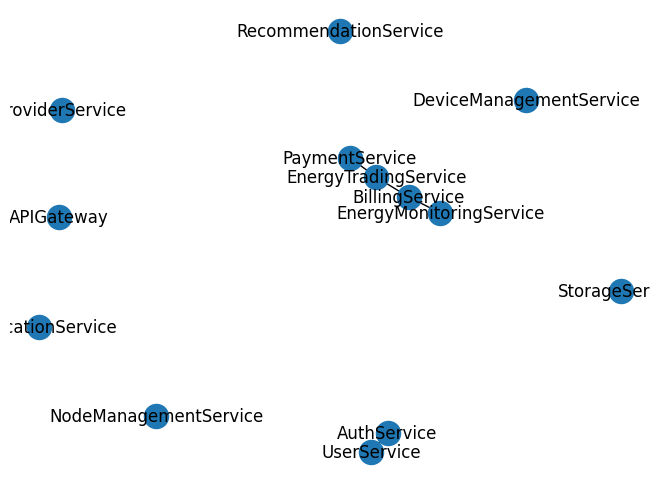

In [546]:
nx.draw(G,  with_labels = True)

In [547]:
# Assuming 'G' is your NetworkX graph
degrees = dict(G.degree())
sum_of_degrees = sum(degrees.values())
average_degree = sum_of_degrees / G.number_of_nodes()

print(f"The average degree of the graph is: {average_degree}")

The average degree of the graph is: 0.6153846153846154


In [513]:
# User Stories Satisfaction Coverage

In [311]:
with open('/Users/marcocalamo/Downloads/DataMetrics (15).json') as json_data:
    d = json.load(json_data)
    print(d)


[{'set_id': 1, 'set_name': 'auth client', 'user_stories': [1, 2], 'links': [2, 3], 'db': 'false'}, {'set_id': 2, 'set_name': 'user profile', 'user_stories': [3, 4, 5, 6, 7, 11, 13], 'links': [1, 4], 'db': 'true'}, {'set_id': 3, 'set_name': 'notifications', 'user_stories': [18], 'links': [2], 'db': 'true'}, {'set_id': 4, 'set_name': 'shopping list', 'user_stories': [12, 16, 20, 21, 22], 'links': [2, 5], 'db': 'true'}, {'set_id': 5, 'set_name': 'recipes and ingredients', 'user_stories': [10, 12, 14], 'links': [4, 6], 'db': 'true'}, {'set_id': 6, 'set_name': 'storage', 'user_stories': [8, 9, 15, 17, 19], 'links': [4], 'db': 'true'}, {'set_id': 7, 'set_name': 'frontend', 'user_stories': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22], 'links': [1, 2, 3, 4, 5, 6], 'db': 'false'}]


In [232]:
set([ddx for dx in d for ddx in dx['user_stories']])

{1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36}

In [325]:
set([ddx for dx in json.loads(str_res)["microservices"] for ddx in dx['user_stories']])

{'1',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '19',
 '2',
 '20',
 '21',
 '22',
 '23',
 '25',
 '26',
 '27',
 '28',
 '29',
 '3',
 '30',
 '31',
 '32',
 '33',
 '34',
 '35',
 '36',
 '37',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9'}

In [477]:
def num_services(gen):
    return len([dx for dx in json.loads(gen)["microservices"]])

In [548]:
num_services(str_res)

13

In [343]:
from functools import reduce
def avg_stories_per_service(gen):
    stories_per_service =  [len(dx['user_stories']) for dx in json.loads(gen)["microservices"]]
    return reduce(lambda a,b: a+b, stories_per_service)/len(stories_per_service)

In [549]:
avg_stories_per_service(str_res)

[0, 2, 1, 3, 1, 2, 1, 1, 3, 2, 1, 3, 2]


1.6923076923076923

In [184]:
def compute_ussc(ref, gen):
    set_ref = set([ddx for dx in ref for ddx in dx['user_stories']])
    set_gen = set([int(ddx) for dx in json.loads(gen[1])["microservices"] for ddx in dx['user_stories']])

    print(len(set_gen))
    prec = len(set_ref.intersection(set_gen)) / len(set_ref)
    return prec

In [123]:
def _extract_max_clique(gen):
    # Create and format prompt template
    nx_prompt = RichPromptTemplate(NETWORKX_PROMPT)
    nx_query = nx_prompt.format(input_json=gen[1])

    llm = OpenAI(model="gpt-4o-mini")

    # Execute prompt and format result
    resp = llm.complete(nx_query).text

    html = markdown(resp)
    text = ''.join(BeautifulSoup(html).findAll(string=True))
    G = nx.from_dict_of_lists(ast.literal_eval(text[4:])) # first 4 are json letters
    return [c for c in nx.find_cliques(G)]
def compute_ge(gen):
    c_tot = len(json.loads(gen[1])["microservices"])
    clique_no = len(_extract_max_clique(gen))

    if c_tot <= clique_no:
        return c_tot / clique_no * 100
    else:
        return float( 'nan' )
    pass

In [312]:
compute_ussc(d, result)

22


1.0

In [125]:
compute_ge(result)

nan

# Run Workflow [OLD]

In [ ]:
w = CitationQueryEngineWorkflow(timeout=None)

In [ ]:
result = await w.run(query="What microservices architecture pattern exist? Enumerate them all", retriever=retriever)

In [ ]:
display(Markdown(f"{result}"))

In [ ]:
for source in result.source_nodes:
    print(source.node.get_text())

In [ ]:
# flusso microservizi per backend modulare 
# - base dati per ogni servizio(o una o nessuna)
# - check per saga pattern in maniera specifica su quali servizi sono coinvoliti, oppure fai check su saga dopo. Fai CQRS check dopo in base al traffico che ti aspetti
# - secondo json per i pattern implementativi
# flusso usecases per frontend monolitico con tipologie di utenti

# Import Excel

In [668]:
import os.path

from google.auth.transport.requests import Request
from google.oauth2.credentials import Credentials
from google_auth_oauthlib.flow import InstalledAppFlow
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError

# If modifying these scopes, delete the file token.json.
SCOPES = ["https://www.googleapis.com/auth/spreadsheets.readonly"]

# The ID and range of a sample spreadsheet.
SAMPLE_SPREADSHEET_ID = "1T3BLOBFn1-DEBMvlb-wTEMDcE109ET0NK-LVacTcljQ"
SAMPLE_RANGE_NAME = "USERSTORIES!A1:D17"


def main():
  """Shows basic usage of the Sheets API.
  Prints values from a sample spreadsheet.
  """
  creds = None
  # The file token.json stores the user's access and refresh tokens, and is
  # created automatically when the authorization flow completes for the first
  # time.
  if os.path.exists("token.json"):
    creds = Credentials.from_authorized_user_file("token.json", SCOPES)
  # If there are no (valid) credentials available, let the user log in.
  if not creds or not creds.valid:
    if creds and creds.expired and creds.refresh_token:
      creds.refresh(Request())
    else:
      flow = InstalledAppFlow.from_client_secrets_file(
          "/Users/marcocalamo/Downloads/client_secret_322427361191-3mv4kdhbub1b5feb77ria2dqe27nima9.apps.googleusercontent.com.json", SCOPES
      )
      creds = flow.run_local_server(port=0)
    # Save the credentials for the next run
    with open("token.json", "w") as token:
      token.write(creds.to_json())

  try:
    service = build("sheets", "v4", credentials=creds)

    # Call the Sheets API
    sheet = service.spreadsheets()
    result = (
        sheet.values()
        .get(spreadsheetId=SAMPLE_SPREADSHEET_ID, range=SAMPLE_RANGE_NAME)
        .execute()
    )
    values = result.get("values", [])

    if not values:
      print("No data found.")
      return

    print("Name, Major:")
    for row in values:
      # Print columns A and E, which correspond to indices 0 and 4.
      print(f"{row[0]}, {(row[3].replace(',', '.'))}")
    return values
  except HttpError as err:
    print(err)


if __name__ == "__main__":
  values = main()

Name, Major:
USER STORIES EVALUATION, Satisfied percentage
4-by-4, 94.59
CDC, 92.00
chronopic, 100.00
EFarmers, 97.22
EventTicket, 90.00
ExamRush, 100.00
LuckyBets, 100.00
Ndannamo, 95.59
Nestigo, 94.12
NFFH, 100.00
OneSport, 100.00
RecipeCove, 100.00
RentYourExpert, 97.14
SmartCuisine, 100.00
Teamify, 100.00
WattsUp, 95.65


In [564]:
import pandas as pd

In [613]:
def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

In [669]:
values_2 = [float(y.replace(',', '.')) if is_number(y.replace(',', '.')) else y for x in values for y in x ]

In [670]:
values_2 = [values_2[i:i+4] for i in range(0, len(values_2), 4)]

In [671]:
values_2

[['USER STORIES EVALUATION',
  '# User Stories',
  '# Satisfied User Stories',
  'Satisfied percentage'],
 ['4-by-4', 37.0, 35.0, 94.59],
 ['CDC', 25.0, 23.0, 92.0],
 ['chronopic', 15.0, 15.0, 100.0],
 ['EFarmers', 36.0, 35.0, 97.22],
 ['EventTicket', 20.0, 18.0, 90.0],
 ['ExamRush', 11.0, 11.0, 100.0],
 ['LuckyBets', 19.0, 19.0, 100.0],
 ['Ndannamo', 68.0, 65.0, 95.59],
 ['Nestigo', 17.0, 16.0, 94.12],
 ['NFFH', 41.0, 41.0, 100.0],
 ['OneSport', 24.0, 24.0, 100.0],
 ['RecipeCove', 14.0, 14.0, 100.0],
 ['RentYourExpert', 35.0, 34.0, 97.14],
 ['SmartCuisine', 22.0, 22.0, 100.0],
 ['Teamify', 31.0, 31.0, 100.0],
 ['WattsUp', 23.0, 22.0, 95.65]]

In [672]:
user_stories = pd.DataFrame(values_2[1:], columns=values_2[0])

In [675]:
endpoints

,ENDPOINT EVALUATION,# Endpoints,# Generated Correct Endpoints,Satisfied Percentage
0,4-by-4,4.0,0.0,0.00
1,CDC,10.0,10.0,100.00
2,chronopic,18.0,18.0,100.00
3,EFarmers,53.0,42.0,79.25
4,EventTicket,18.0,18.0,100.00
5,ExamRush,10.0,10.0,100.00
6,LuckyBets,4.0,4.0,100.00
7,Ndannamo,50.0,24.0,48.00
8,Nestigo,10.0,10.0,100.00
9,NFFH,26.0,26.0,100.00


In [639]:
patterns =  pd.DataFrame(values_2[1:], columns=values_2[0])

In [646]:
patterns["# Avg. Links per servicess"]

0     3.42
1     3.25
2     3.40
3     3.00
4     3.14
5     0.00
6     3.33
7     1.42
8     5.00
9     9.00
10    0.80
11    0.44
12    1.66
13    2.00
14    5.00
15    0.61
Name: # Avg. Links per services, dtype: float64

In [624]:
endpoints = pd.DataFrame(values_2[1:], columns=values_2[0])

In [628]:
endpoints["ENDPOINT EVALUATION"]

0             4-by-4
1                CDC
2          chronopic
3           EFarmers
4        EventTicket
5           ExamRush
6          LuckyBets
7           Ndannamo
8            Nestigo
9               NFFH
10          OneSport
11        RecipeCove
12    RentYourExpert
13      SmartCuisine
14           Teamify
15           WattsUp
Name: ENDPOINT EVALUATION, dtype: object

In [633]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_endpoints(endpoints):

    # Create the DataFrame from your data
    data = endpoints 
    
    """{
        'ENDPOINT': ['4-by-4', 'CDC', 'chronopic', 'EFarmers', 'EventTicket', 'ExamRush', 
                     'LuckyBets', 'Ndannamo', 'Nestigo', 'NFFH', 'OneSport', 'RecipeCove', 
                     'RentYourExpert', 'SmartCuisine', 'Teamify', 'WattsUp'],
        'EVALUATION': ['None'] * 16,
        '# Endpoints': [4, 10, 18, 53, 18, 10, 4, 50, 10, 26, 25, 1, 38, 26, 1, 68],
        '# Generated Correct Endpoints': [4, 10, 18, 42, 18, 10, 4, 24, 10, 26, 25, 0, 38, 26, 0, 18],
        'Satisfied Percentage': [100.0, 100.0, 100.0, 79.25, 100.0, 100.0, 100.0, 48.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 26.47],
        'Total Avg': ['None'] * 16
    }"""
    
    df = pd.DataFrame(data)
    
    # Set up the plot style
    plt.style.use('seaborn-v0_8')
    sns.set_palette("husl")
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(15, 8))
    
    # Create the bubble plot
    scatter = ax.scatter(
        x=range(len(df['ENDPOINT EVALUATION'])), 
        y=df['# Generated Correct Endpoints'],
        s=df['# Endpoints'] * 10,  # Scale bubble size (multiply by 10 for better visibility)
        c=df['Satisfied Percentage'],  # Color by satisfaction percentage
        cmap='RdYlGn',  # Red-Yellow-Green colormap
        alpha=0.7,
        edgecolors='black',
        linewidth=0.5
    )
    
    # Customize the plot
    ax.set_xlabel('Endpoint Names', fontsize=12, fontweight='bold')
    ax.set_ylabel('Number of Generated Correct Endpoints', fontsize=12, fontweight='bold')
    ax.set_title('Endpoint Performance Analysis\n(Bubble Size = Total Endpoints, Color = Satisfaction %)', 
                 fontsize=14, fontweight='bold', pad=20)
    
    # Set x-axis labels
    ax.set_xticks(range(len(df['ENDPOINT EVALUATION'])))
    ax.set_xticklabels(df['ENDPOINT EVALUATION'], rotation=45, ha='right')
    
    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Satisfaction Percentage (%)', fontsize=11, fontweight='bold')
    
    # Add grid for better readability
    ax.grid(True, alpha=0.3)
    
    # Add annotations for interesting points
    #for i, row in df.iterrows():
    #    if row['Satisfied Percentage'] < 80 or row['# Endpoints'] > 50:
    #        ax.annotate(
    #            f"{row['ENDPOINT EVALUATION']}\n({row['# Generated Correct Endpoints']}/{row['# Endpoints']})",
    #            (i, row['# Generated Correct Endpoints']),
    #            xytext=(10, 10), textcoords='offset points',
    #            bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7),
    #            arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'),
    #            fontsize=8
    #        )
    
    # Add legend for bubble sizes
    legend_sizes = [10, 30, 50]
    legend_labels = ['Small (≤10)', 'Medium (≤30)', 'Large (≥50)']
    legend_bubbles = []
    
    for size in legend_sizes:
        legend_bubbles.append(plt.scatter([], [], s=size*10, c='gray', alpha=0.6, edgecolors='black'))
    
    legend1 = ax.legend(legend_bubbles, legend_labels, 
                       title='Total Endpoints', loc='upper left', 
                       bbox_to_anchor=(0.02, 0.98), frameon=True, fancybox=True, shadow=True)
    legend1.get_title().set_fontweight('bold')
    
    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    
    # Display statistics
    print("Dataset Statistics:")
    print(f"Total Endpoints: {len(df)}")
    print(f"Average Generated Correct Endpoints: {df['# Generated Correct Endpoints'].mean():.2f}")
    print(f"Average Satisfaction Percentage: {df['Satisfied Percentage'].mean():.2f}%")
    print(f"Highest Performing Endpoint: {df.loc[df['Satisfied Percentage'].idxmax(), 'ENDPOINT EVALUATION']}")
    print(f"Lowest Performing Endpoint: {df.loc[df['Satisfied Percentage'].idxmin(), 'ENDPOINT EVALUATION']}")
    
    # Show the plot
    plt.show()

    """
    # Optional: Save the plot
    # plt.savefig('endpoint_bubble_plot.png', dpi=300, bbox_inches='tight')
    
    # Alternative version using seaborn's scatterplot (more seaborn-native approach)
    print("\n" + "="*50)
    print("Alternative Seaborn Version:")
    print("="*50)
    
    # Create a second plot using seaborn's scatterplot
    plt.figure(figsize=(15, 8))
    
    # Create the seaborn scatterplot
    sns.scatterplot(
        data=df,
        x='ENDPOINT EVALUATION',
        y='# Generated Correct Endpoints',
        size='# Endpoints',
        hue='Satisfied Percentage',
        sizes=(50, 500),  # Min and max bubble sizes
        alpha=0.7,
        palette='RdYlGn'
    )
    
    # Customize the seaborn plot
    plt.xlabel('Endpoint Names', fontsize=12, fontweight='bold')
    plt.ylabel('Number of Generated Correct Endpoints', fontsize=12, fontweight='bold')
    plt.title('Endpoint Performance Analysis (Seaborn Version)\n(Bubble Size = Total Endpoints, Color = Satisfaction %)', 
              fontsize=14, fontweight='bold', pad=20)
    
    # Rotate x-axis labels
    plt.xticks(rotation=45, ha='right')
    
    # Add grid
    plt.grid(True, alpha=0.3)
    
    # Adjust layout
    plt.tight_layout()
    
    # Show the seaborn plot
    plt.show()
    
    # Create a summary table
    print("\n" + "="*50)
    print("Summary Table:")
    print("="*50)
    summary_df = df[['ENDPOINT EVALUATION', '# Endpoints', '# Generated Correct Endpoints', 'Satisfied Percentage']].copy()
    summary_df['Success Rate'] = (summary_df['# Generated Correct Endpoints'] / summary_df['# Endpoints'] * 100).round(2)
    summary_df = summary_df.sort_values('Satisfied Percentage', ascending=False)
    print(summary_df.to_string(index=False))"""

Dataset Statistics:
Total Endpoints: 16
Average Generated Correct Endpoints: 16.81
Average Satisfaction Percentage: 72.11%
Highest Performing Endpoint: CDC
Lowest Performing Endpoint: 4-by-4


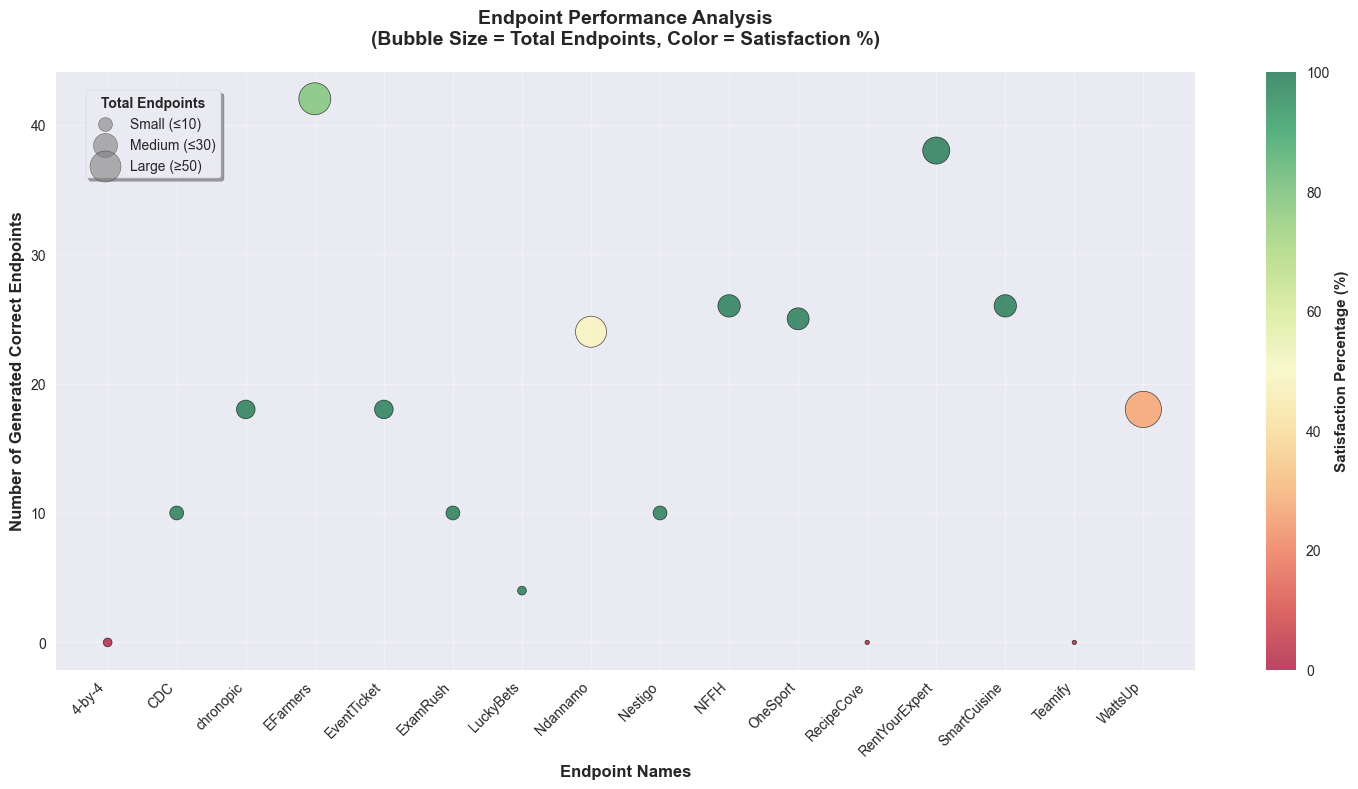

In [634]:
plot_endpoints(endpoints)

In [666]:
def plot_patterns(patterns):

    df = patterns
    
    # Set up the plot style
    plt.style.use('seaborn-v0_8')
    sns.set_palette("husl")
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(16, 10))
    #Create the bubble plot
    scatter = ax.scatter(
        x=range(len(df['PATTERN/PERSISTANCE EVALUATION'])), 
        y=df['# Avg. Stories per service'],  # Y-axis: Average Stories per Service
        s=df['# Services Gen'] * 20,  # Bubble size: Number of Services Generated
        c=df['# Avg. Links per services'],  # Color by average links per service
        cmap='RdYlGn',
        alpha=0.7,
        edgecolors='black',
        linewidth=1
    )
    
    # Customize the plot
    ax.set_xlabel('Endpoint Names', fontsize=14, fontweight='bold')
    ax.set_ylabel('Average Stories per Service', fontsize=14, fontweight='bold')
    ax.set_title('Pattern/Persistence Evaluation Analysis\n(Bubble Size = # Services Generated, Color = Avg. Links per services)', 
                 fontsize=16, fontweight='bold', pad=20)
    
    # Set x-axis labels
    ax.set_xticks(range(len(df['PATTERN/PERSISTANCE EVALUATION'])))
    ax.set_xticklabels(df['PATTERN/PERSISTANCE EVALUATION'], rotation=45, ha='right', fontsize=11)
    
    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Average Links per Service', fontsize=12, fontweight='bold')
    
    # Add grid for better readability
    ax.grid(True, alpha=0.3)
    
    # Add annotations for interesting points
    #for i, row in df.iterrows():
        # Annotate high performers and outliers
    #    if (row['# Services Gen'] >= 13 or 
    #        row['# Avg. Stories per service'] >= 5.0 or 
    #        row['# Avg. Links per services'] >= 5.0 or
    #        row['# Avg. Links per services'] == 0.0):
            
    #        ax.annotate(
    #            f"{row['PATTERN/PERSISTANCE EVALUATION']}\n"
    #            f"Services: {row['# Services Gen']}\n"
    #            f"Stories: {row['# Avg. Stories per service']:.2f}\n"
    #            f"Links: {row['# Avg. Links per services']:.2f}",
    #            (i, row['# Avg. Stories per service']),
    #            xytext=(15, 15), textcoords='offset points',
    #            bbox=dict(boxstyle='round,pad=0.5', facecolor='lightblue', alpha=0.8),
    #            arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.2'),
    #            fontsize=9
    #        )
    
    # Add legend for bubble sizes
    service_ranges = [6, 10, 15]
    legend_labels = ['Small Services (≤6)', 'Medium Services (≤10)', 'Big Services (≥15)']
    legend_bubbles = []
    
    for size in service_ranges:
        legend_bubbles.append(plt.scatter([], [], s=size*20, c='gray', alpha=0.6, edgecolors='black'))
    
    legend1 = ax.legend(legend_bubbles, legend_labels, 
                       title='# Services Generated', loc='upper left', 
                       bbox_to_anchor=(0.02, 0.98), frameon=True, fancybox=True, shadow=True)
    legend1.get_title().set_fontweight('bold')
    
    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    
    # Display statistics
    print("Pattern/Persistence Dataset Statistics:")
    print("=" * 50)
    print(f"Total Endpoints: {len(df)}")
    print(f"Average Services Generated: {df['# Services Gen'].mean():.2f}")
    print(f"Average Stories per Service: {df['# Avg. Stories per service'].mean():.2f}")
    print(f"Average Links per Service: {df['# Avg. Links per services'].mean():.2f}")
    print(f"Highest Service Generator: {df.loc[df['# Services Gen'].idxmax(), 'PATTERN/PERSISTANCE EVALUATION']} ({df['# Services Gen'].max()} services)")
    print(f"Highest Stories per Service: {df.loc[df['# Avg. Stories per service'].idxmax(), 'PATTERN/PERSISTANCE EVALUATION']} ({df['# Avg. Stories per service'].max():.2f} stories)")
    print(f"Highest Links per Service: {df.loc[df['# Avg. Links per services'].idxmax(), 'PATTERN/PERSISTANCE EVALUATION']} ({df['# Avg. Links per services'].max():.2f} links)")
    
    # Show the plot
    plt.show()


Pattern/Persistence Dataset Statistics:
Total Endpoints: 16
Average Services Generated: 8.75
Average Stories per Service: 3.33
Average Links per Service: 2.84
Highest Service Generator: EFarmers (15.0 services)
Highest Stories per Service: RentYourExpert (5.66 stories)
Highest Links per Service: NFFH (9.00 links)


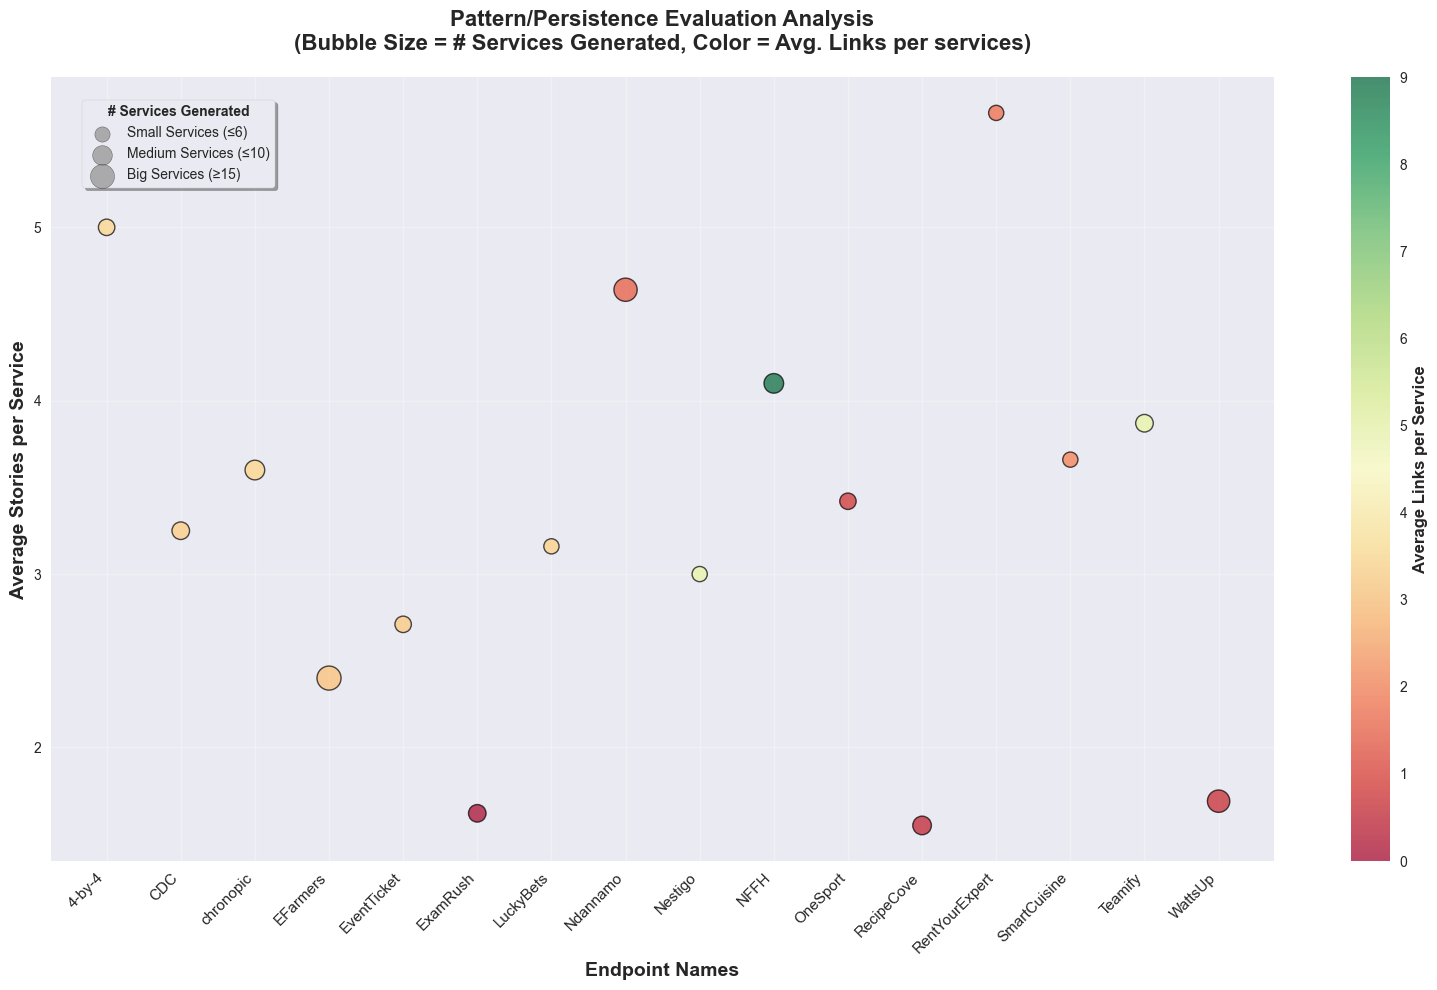

In [667]:
plot_patterns(patterns)

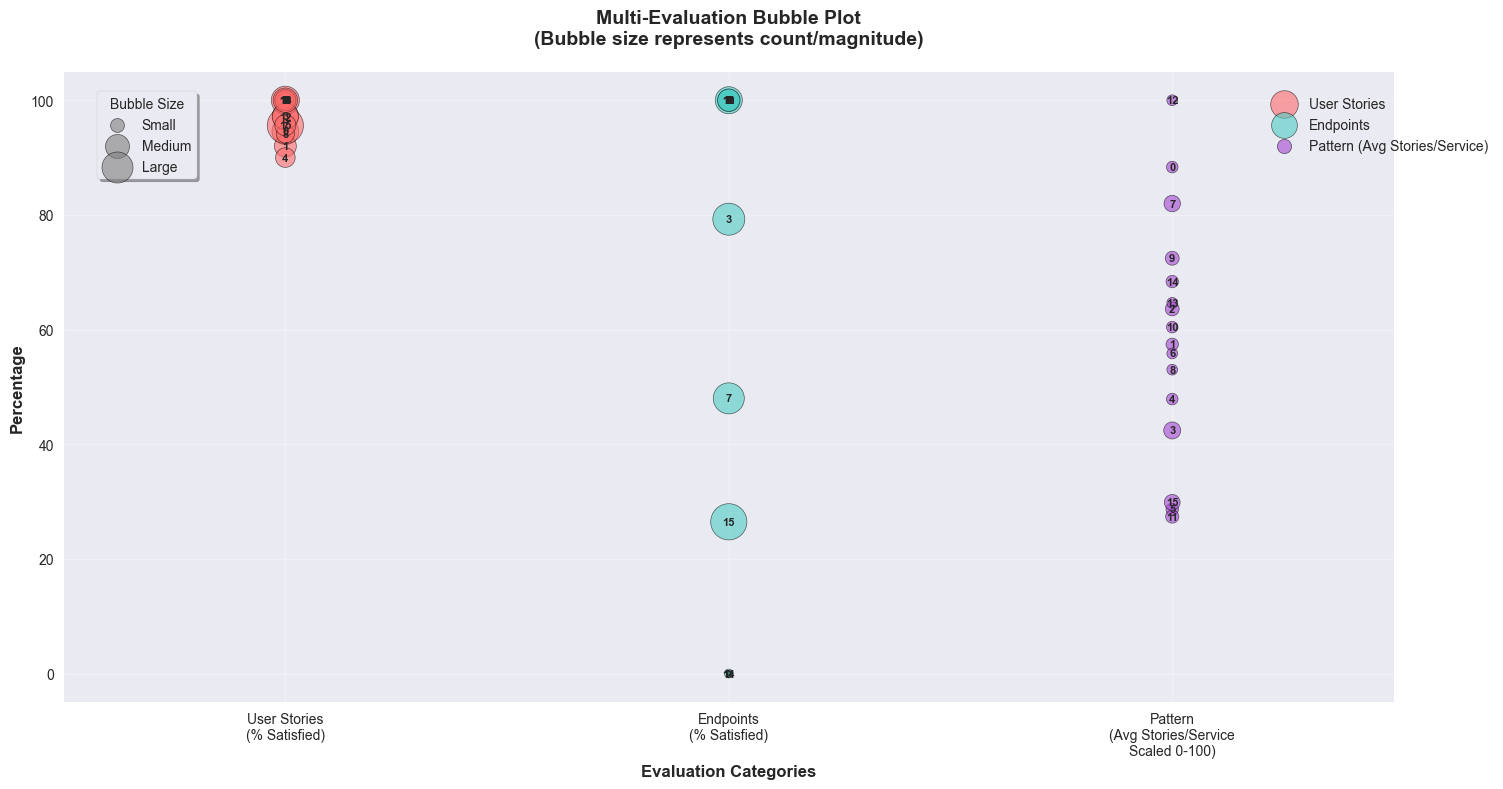

In [686]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def create_evaluation_bubble_plot(user_stories_df, pattern_df, endpoint_df, figsize=(15, 8)):
    """
    Create a bubble plot combining user stories, pattern, and endpoint evaluations.
    
    Parameters:
    - user_stories_df: DataFrame with columns ['# User Stories', 'Satisfied percentage']
    - pattern_df: DataFrame with columns ['# Services Gen', 'Avg. Stories per service']
    - endpoint_df: DataFrame with columns ['# Endpoints', 'Satisfied Percentage']
    - figsize: tuple for figure size
    """
    
    # Prepare data for user stories
    user_stories_data = []
    for idx, row in user_stories_df.iterrows():
        user_stories_data.append({
            'Category': 'User Stories',
            'Case': idx,
            'Y_Value': row['Satisfied percentage'],
            'Bubble_Size': row['# User Stories'],
            'X_Position': 0  # First column
        })
    
    # Prepare data for endpoints
    endpoint_data = []
    for idx, row in endpoint_df.iterrows():
        endpoint_data.append({
            'Category': 'Endpoints',
            'Case': idx,
            'Y_Value': row['Satisfied Percentage'],
            'Bubble_Size': row['# Endpoints'],
            'X_Position': 1  # Second column
        })
    
    # Prepare data for pattern (scale avg stories per service to 0-100)
    pattern_data = []
    max_avg_stories = pattern_df['Avg. Stories per service'].max()
    for idx, row in pattern_df.iterrows():
        scaled_value = (row['Avg. Stories per service'] / max_avg_stories) * 100
        pattern_data.append({
            'Category': 'Pattern (Avg Stories/Service)',
            'Case': idx,
            'Y_Value': scaled_value,
            'Bubble_Size': row['# Services Gen'],
            'X_Position': 2  # Third column
        })
    
    # Combine all data
    all_data = user_stories_data + endpoint_data + pattern_data
    df_combined = pd.DataFrame(all_data)
    
    # Create the plot
    plt.figure(figsize=figsize)
    
    # Define colors for each category
    colors = ['#FF6B6B', '#4ECDC4', '#a545d1']
    categories = ['User Stories', 'Endpoints', 'Pattern (Avg Stories/Service)']
    
    # Create scatter plot for each category
    for i, category in enumerate(categories):
        category_data = df_combined[df_combined['Category'] == category]
        
        # Scale bubble sizes for better visualization
        bubble_sizes = category_data['Bubble_Size'] * 10  # Scale factor for visibility
        
        plt.scatter(
            category_data['X_Position'], 
            category_data['Y_Value'],
            s=bubble_sizes,
            c=colors[i],
            alpha=0.6,
            label=category,
            edgecolors='black',
            linewidth=0.5
        )
        
        # Add case labels to bubbles
        for idx, row in category_data.iterrows():
            plt.annotate(
                f'{row["Case"]}',
                (row['X_Position'], row['Y_Value']),
                xytext=(0, 0),
                textcoords='offset points',
                ha='center',
                va='center',
                fontsize=8,
                weight='bold'
            )
    
    # Customize the plot
    plt.xlabel('Evaluation Categories', fontsize=12, fontweight='bold')
    plt.ylabel('Satisfaction/Performance Percentage', fontsize=12, fontweight='bold')
    plt.title('Multi-Evaluation Bubble Plot\n(Bubble size represents count/magnitude)', 
              fontsize=14, fontweight='bold', pad=20)
    
    # Set x-axis
    plt.xticks([0, 1, 2], ['User Stories\n(% Satisfied)', 'Endpoints\n(% Satisfied)', 'Pattern\n(Avg Stories/Service\nScaled 0-100)'])
    plt.xlim(-0.5, 2.5)
    
    # Set y-axis
    plt.ylim(-5, 105)
    plt.ylabel('Percentage', fontsize=12, fontweight='bold')
    
    # Add grid
    plt.grid(True, alpha=0.3)
    
    # Add legend
    plt.legend(loc='upper right', bbox_to_anchor=(1.0, 1.0))
    
    # Add bubble size legend
    legend_sizes = [10, 30, 50]
    legend_labels = ['Small', 'Medium', 'Large']
    
    for i, (size, label) in enumerate(zip(legend_sizes, legend_labels)):
        plt.scatter([], [], s=size*10, c='gray', alpha=0.6, 
                   edgecolors='black', linewidth=0.5)
    
    # Create a separate legend for bubble sizes
    size_legend = plt.legend(
        [plt.scatter([], [], s=s*10, c='gray', alpha=0.6, 
                    edgecolors='black', linewidth=0.5) for s in legend_sizes],
        legend_labels,
        title="Bubble Size",
        loc='upper left',
        bbox_to_anchor=(0.02, 0.98),
        frameon=True,
        fancybox=True,
        shadow=True
    )
    
    # Add the category legend back
    plt.legend(loc='upper right', bbox_to_anchor=(1.08, 0.98))
    plt.gca().add_artist(size_legend)
    
    plt.tight_layout()
    return plt.gcf()

# Example usage with sample data
if __name__ == "__main__":
    # Sample data based on your tables
    user_stories_data = {
        '# User Stories': [37, 25, 15, 36, 20, 11, 19, 68, 17, 41, 24, 14, 35, 22, 31, 23],
        'Satisfied percentage': [94.59, 92.00, 100.00, 97.22, 90.00, 100.00, 100.00, 95.59, 94.12, 100.00, 100.00, 100.00, 97.14, 100.00, 100.00, 95.65]
    }
    
    pattern_data = {
        '# Services Gen': [7, 8, 10, 15, 7, 8, 6, 14, 6, 10, 7, 9, 6, 6, 8, 13],
        'Avg. Stories per service': [5.00, 3.25, 3.60, 2.40, 2.71, 1.62, 3.16, 4.64, 3.00, 4.10, 3.42, 1.55, 5.66, 3.66, 3.87, 1.69]
    }
    
    endpoint_data = {
        '# Endpoints': [4, 10, 18, 53, 18, 10, 4, 50, 10, 26, 25, 1, 38, 26, 1, 68],
        'Satisfied Percentage': [0.00, 100.00, 100.00, 79.25, 100.00, 100.00, 100.00, 48.00, 100.00, 100.00, 100.00, 0.00, 100.00, 100.00, 0.00, 26.47]
    }
    
    # Create DataFrames
    user_stories_df = pd.DataFrame(user_stories_data)
    pattern_df = pd.DataFrame(pattern_data)
    endpoint_df = pd.DataFrame(endpoint_data)
    
    # Create the plot
    fig = create_evaluation_bubble_plot(user_stories_df, pattern_df, endpoint_df)
    plt.show()